In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [15]:
df = pd.read_csv('../data/bike-sharing-demand/train.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


### Statistical decompose the Series to visualize different components

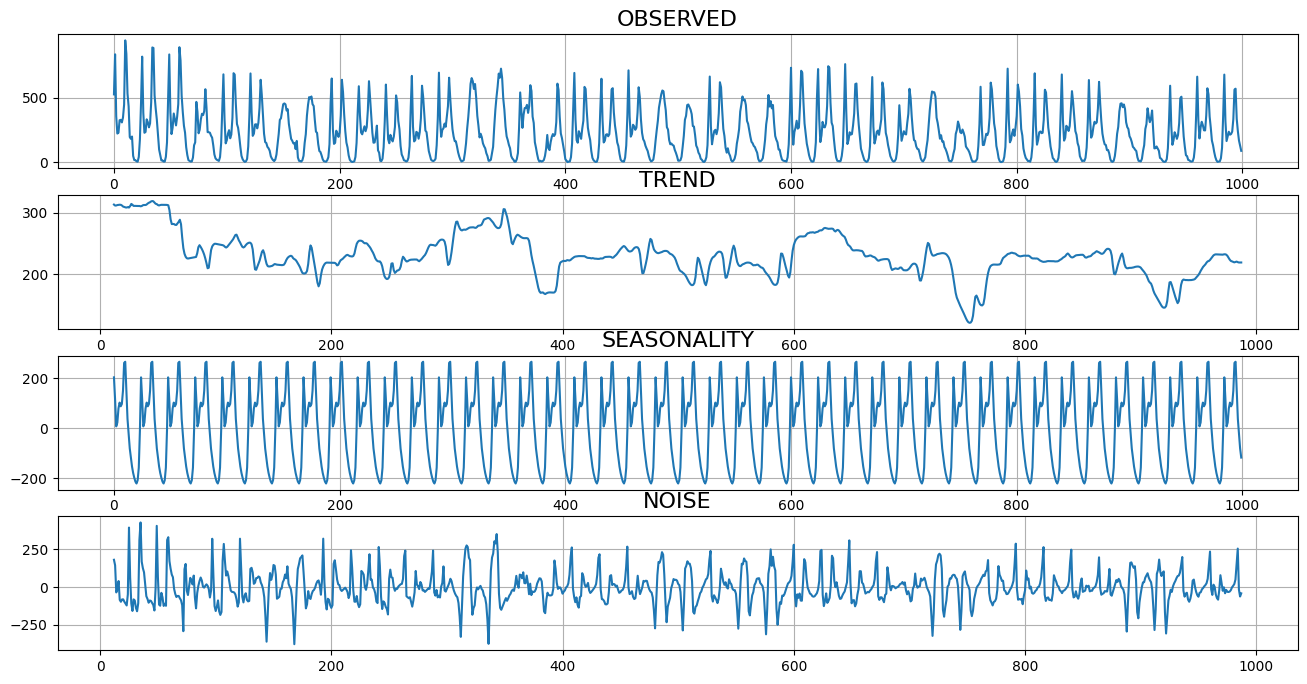

In [10]:
def decompose_bike_sharing_demand(df, share_type='count', samples=250, period=24):
    if samples == 'all':
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    # axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.2)
    axs[3].grid()
    
    plt.show()

decompose_bike_sharing_demand(df, samples=1000, period=24)

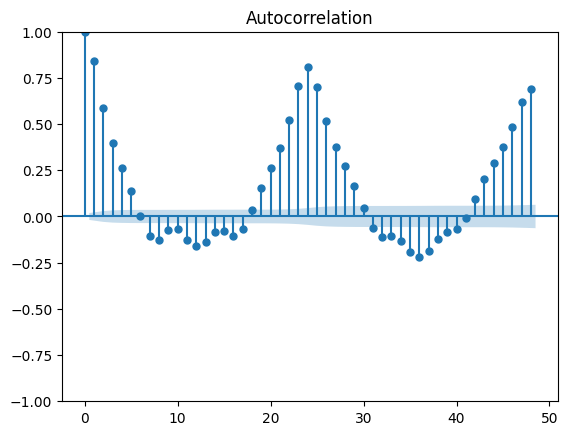

In [17]:
plot_acf(df['count'].values, lags=48)
plt.show()

## Modelling

### Prepare df for timeseries modelling
 - Use Time as Index
 - Remove columns which cannot be derived during infer
 

In [3]:
#convert datetime from object to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
#set datetime as index
df = df.set_index(df.datetime)
#drop datetime column
df.drop('datetime', axis=1, inplace=True)

#create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
#drop casual and registered columns
df.drop(['casual', 'registered'], axis=1, inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1


#### Strategy1: Train with Folds and no Lags

- horizon = number of periods to predict into the future, By default, horizon is set to 24*7, representing a week's worth of hourly data.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 11
[LightGBM] [Info] Start training from score 191.275518


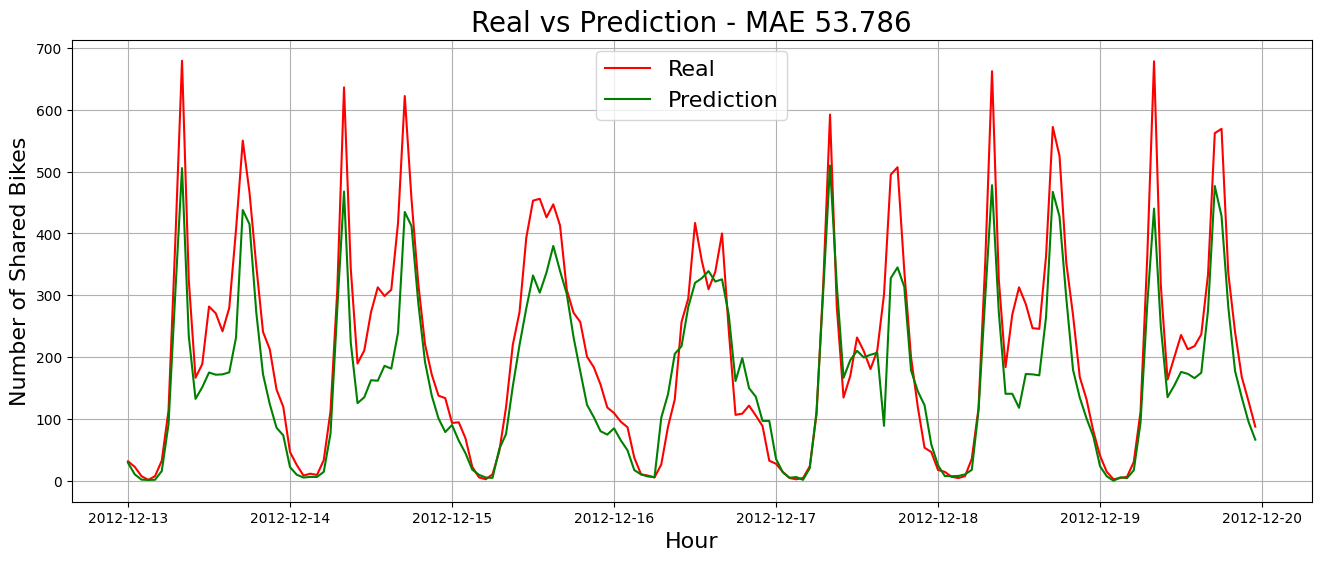

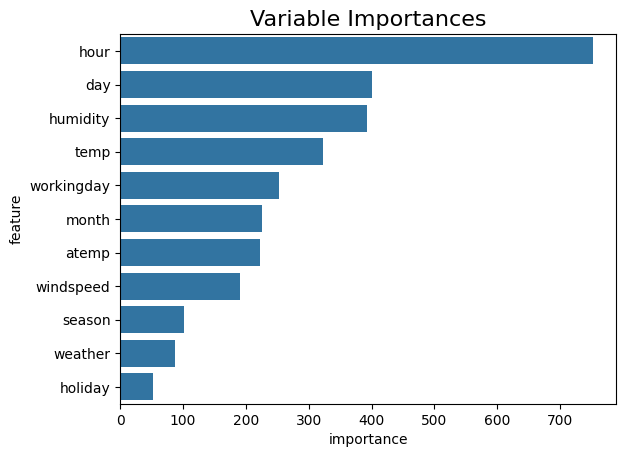

In [4]:
def train_time_series_with_folds(df, horizon=24*7):
    X = df.drop('count', axis=1)
    y = df['count']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

train_time_series_with_folds(df)

### Train with Lags and Folds

In [23]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12


In [5]:
#create 1 week lag variable by shifting the target value for 1 week
df['count_prev_week_same_hour'] = df['count'].shift(24*7)
#drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,count_prev_week_same_hour
datetime,,,,,,,,,,,,,
2011-01-08 07:00:00,1,0,0,2,6.56,9.090,74,7.0015,9,7,8,1,16.0
2011-01-08 08:00:00,1,0,0,3,6.56,9.090,93,7.0015,15,8,8,1,40.0
2011-01-08 09:00:00,1,0,0,3,6.56,9.090,93,7.0015,20,9,8,1,32.0
2011-01-08 10:00:00,1,0,0,2,7.38,9.850,80,11.0014,61,10,8,1,13.0
2011-01-08 11:00:00,1,0,0,2,8.20,9.090,69,26.0027,62,11,8,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12,402.0
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12,268.0
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12,202.0


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 10550, number of used features: 12
[LightGBM] [Info] Start training from score 193.422370


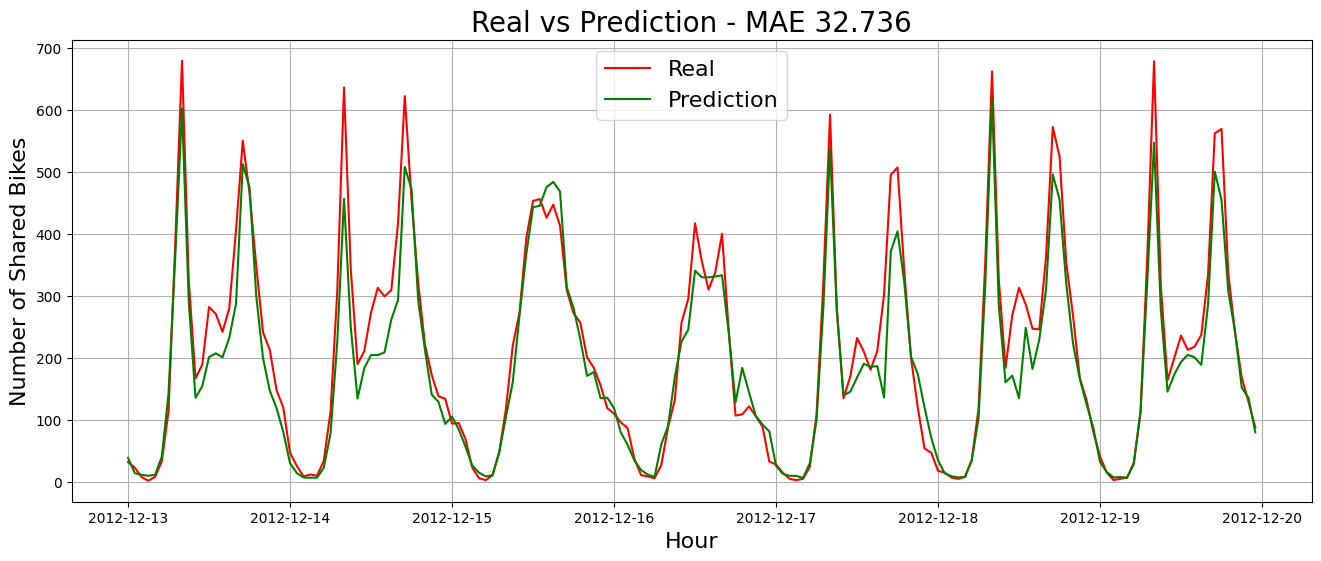

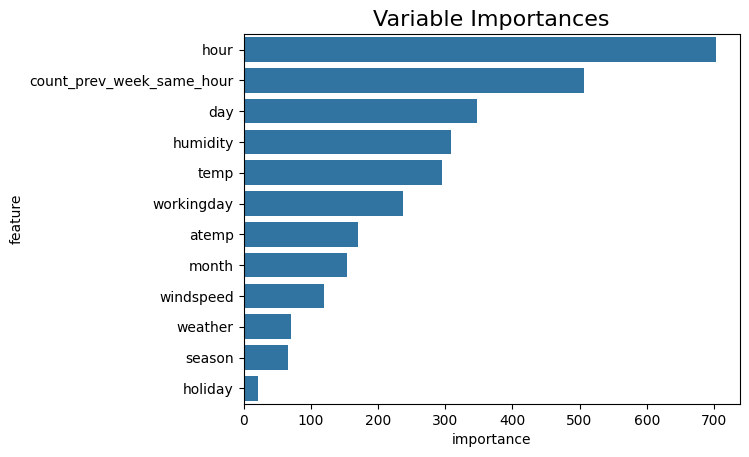

In [6]:
train_time_series_with_folds(df)

### Train Model with Lags + Autorregressive + Prophet Features

In [7]:
from prophet import Prophet
df

/Users/nshukla/miniconda3/envs/time/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,count_prev_week_same_hour
datetime,,,,,,,,,,,,,
2011-01-08 07:00:00,1,0,0,2,6.56,9.090,74,7.0015,9,7,8,1,16.0
2011-01-08 08:00:00,1,0,0,3,6.56,9.090,93,7.0015,15,8,8,1,40.0
2011-01-08 09:00:00,1,0,0,3,6.56,9.090,93,7.0015,20,9,8,1,32.0
2011-01-08 10:00:00,1,0,0,2,7.38,9.850,80,11.0014,61,10,8,1,13.0
2011-01-08 11:00:00,1,0,0,2,8.20,9.090,69,26.0027,62,11,8,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12,402.0
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12,268.0
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12,202.0


In [8]:
def prophet_features(df, horizon=24*7):
    temp_df = df.reset_index()
    temp_df = temp_df[['datetime', 'count']]
    temp_df.rename(columns={'datetime': 'ds', 'count': 'y'}, inplace=True)
    
    #take last week of the dataset for validation
    train, test = temp_df.iloc[:-horizon,:], temp_df.iloc[-horizon:,:]

    m = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False
            )

    m.fit(train)
    predictions_train = m.predict(train.drop('y', axis=1))
    predictions_test = m.predict(test.drop('y', axis=1))
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions

prophet_features(df)

09:59:17 - cmdstanpy - INFO - Chain [1] start processing
09:59:20 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-08 07:00:00,28.397677,-161.793977,290.289565,28.397677,28.397677,34.882233,34.882233,34.882233,25.141811,25.141811,25.141811,9.740423,9.740423,9.740423,0.0,0.0,0.0,63.279911
1,2011-01-08 08:00:00,28.442528,-120.704317,315.291500,28.442528,28.442528,75.692278,75.692278,75.692278,65.916377,65.916377,65.916377,9.775901,9.775901,9.775901,0.0,0.0,0.0,104.134806
2,2011-01-08 09:00:00,28.487379,-116.061290,328.831507,28.487379,28.487379,73.390783,73.390783,73.390783,63.623094,63.623094,63.623094,9.767689,9.767689,9.767689,0.0,0.0,0.0,101.878162
3,2011-01-08 10:00:00,28.532230,-131.883774,313.429031,28.532230,28.532230,52.428164,52.428164,52.428164,42.716266,42.716266,42.716266,9.711897,9.711897,9.711897,0.0,0.0,0.0,80.960394
4,2011-01-08 11:00:00,28.577081,-149.025881,281.253820,28.577081,28.577081,37.208040,37.208040,37.208040,27.603011,27.603011,27.603011,9.605029,9.605029,9.605029,0.0,0.0,0.0,65.785121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2012-12-19 19:00:00,229.267338,182.342411,604.027865,228.019229,230.011566,167.449100,167.449100,167.449100,169.784220,169.784220,169.784220,-2.335120,-2.335120,-2.335120,0.0,0.0,0.0,396.716438
164,2012-12-19 20:00:00,229.248554,75.533796,509.618987,227.991328,229.999292,70.545475,70.545475,70.545475,72.383694,72.383694,72.383694,-1.838219,-1.838219,-1.838219,0.0,0.0,0.0,299.794029
165,2012-12-19 21:00:00,229.229770,-18.790239,429.840996,227.963216,229.986872,-30.298794,-30.298794,-30.298794,-28.979065,-28.979065,-28.979065,-1.319729,-1.319729,-1.319729,0.0,0.0,0.0,198.930976
166,2012-12-19 22:00:00,229.210986,-86.873805,337.714621,227.932669,229.974452,-93.850534,-93.850534,-93.850534,-93.066004,-93.066004,-93.066004,-0.784530,-0.784530,-0.784530,0.0,0.0,0.0,135.360453


13:26:42 - cmdstanpy - INFO - Chain [1] start processing
13:26:43 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5899
[LightGBM] [Info] Number of data points in the train set: 10550, number of used features: 33
[LightGBM] [Info] Start training from score 193.422370


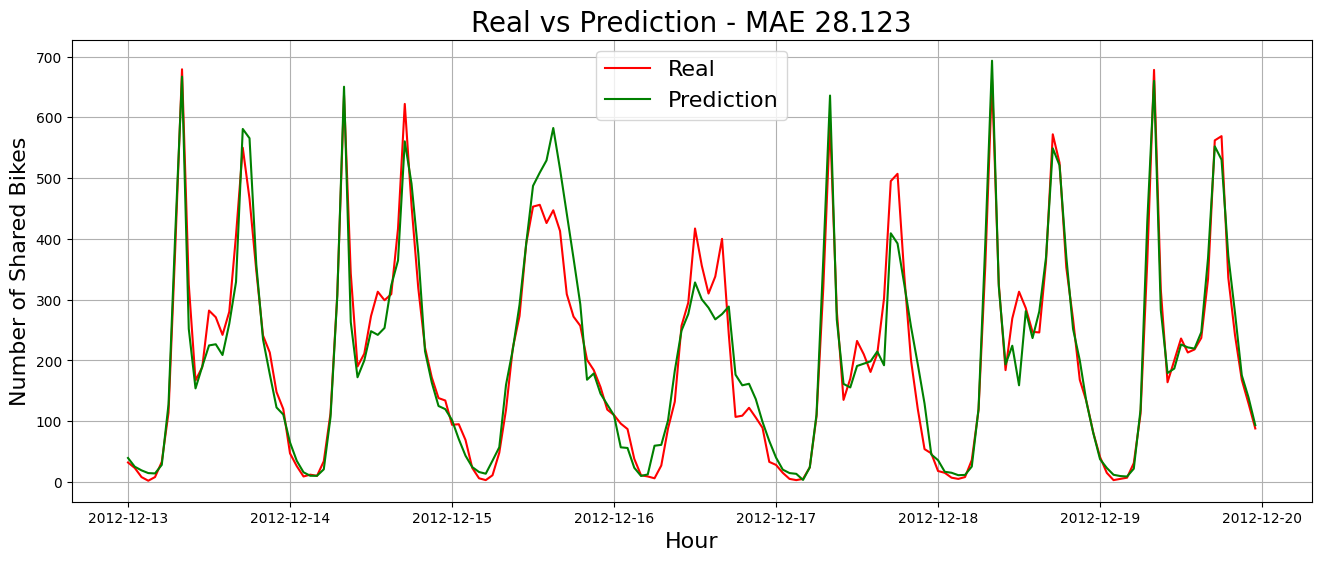

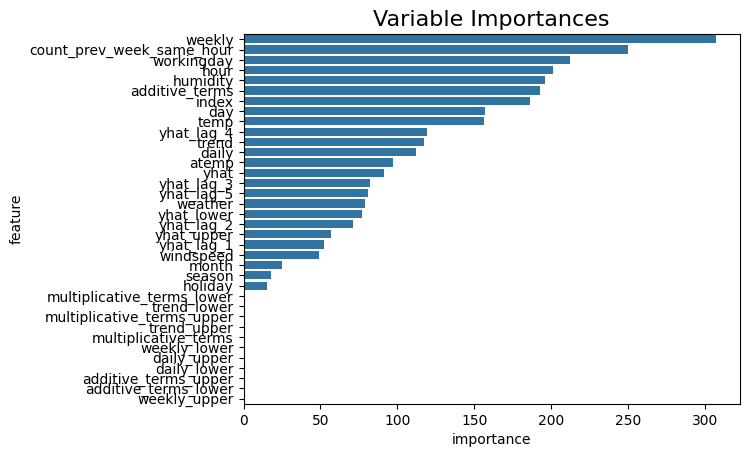

In [10]:
def train_time_series_with_folds_autoreg_prophet_features(df, horizon=24*7, lags=[1, 2, 3, 4, 5]):
    new_prophet_features = prophet_features(df, horizon=horizon)
    df.reset_index(inplace=True)
    
    df = pd.merge(df, new_prophet_features, left_on=['datetime'], right_on=['ds'], how='inner')
    df.drop('ds', axis=1, inplace=True)
    df.set_index('datetime', inplace=True)
    
    for lag in lags:
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
    df.dropna(axis=0, how='any')
    
    X = df.drop('count', axis=1)
    y = df['count']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()

    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

import warnings
warnings.simplefilter('ignore')

train_time_series_with_folds_autoreg_prophet_features(df)

13:41:25 - cmdstanpy - INFO - Chain [1] start processing
13:41:26 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5389
[LightGBM] [Info] Number of data points in the train set: 10718, number of used features: 31
[LightGBM] [Info] Start training from score 191.275518


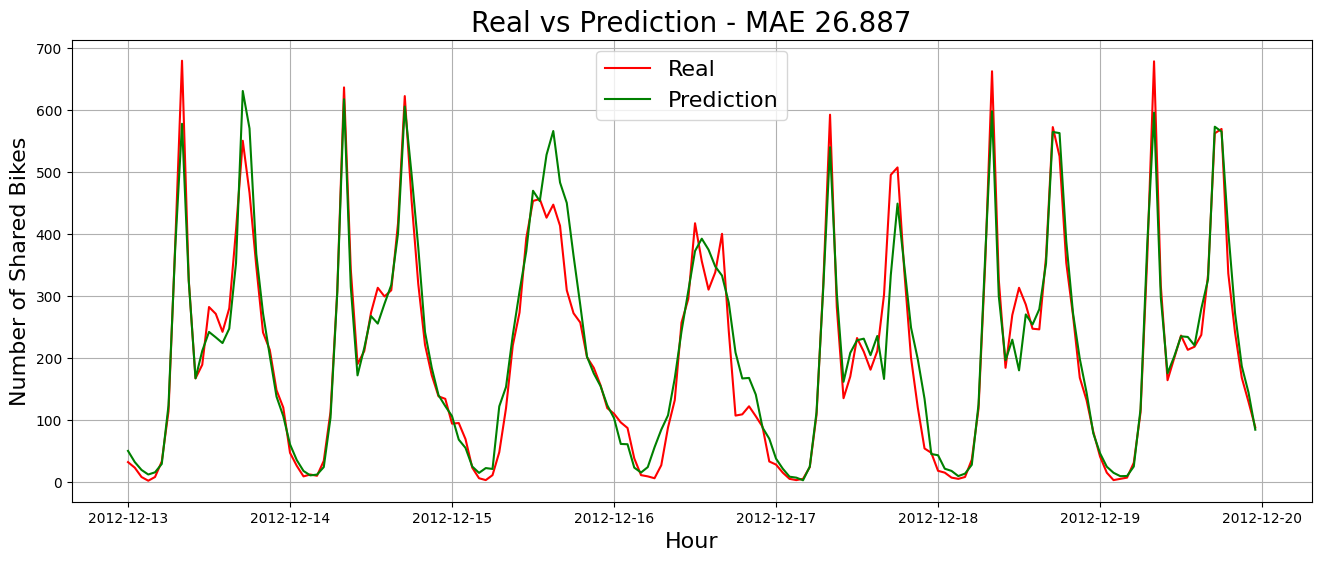

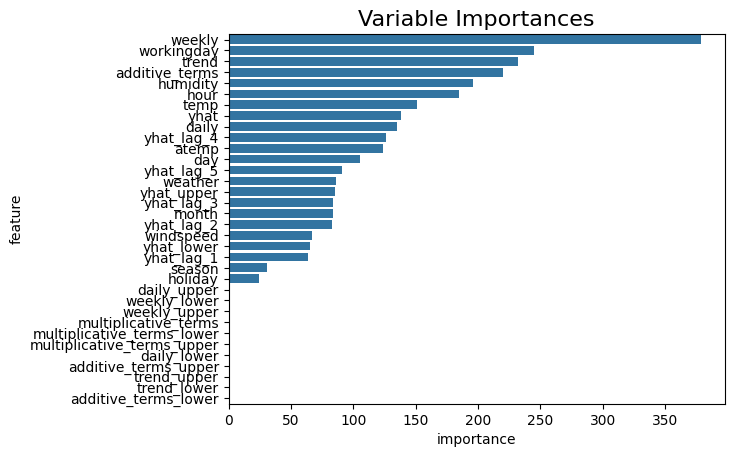

In [32]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def train_time_series_with_folds_autoreg_prophet_features_lineargbm(df, horizon=24*7, lags=[1, 2, 3, 4, 5]):
    new_prophet_features = prophet_features(df, horizon=horizon)
    df.reset_index(inplace=True)
    
    df = pd.merge(df, new_prophet_features, left_on=['datetime'], right_on=['ds'], how='inner')
    df.drop('ds', axis=1, inplace=True)
    df.set_index('datetime', inplace=True)
    
    for lag in lags:
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
    df.dropna(axis=0, how='any')
    
    X = df.drop('count', axis=1)
    y = df['count']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    # Configure and train the LightGBM model with linear_tree
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'linear_tree': True,  # Enable linear tree
        'num_leaves': 10,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'min_data_in_leaf': 5
    }
    train_data = lgb.Dataset(X_train, label=y_train)
    gbm_linear = lgb.train(params, train_data, num_boost_round=200)

    # Forecast the next 12 months using the linear tree model
    y_pred_linear = gbm_linear.predict(X_test)

    # Calculate RMSE for the predictions
    rmse_linear = np.sqrt(mean_absolute_error(y_test, y_pred_linear))
    print(f'RMSE (Linear Tree): {rmse_linear}')

    # Plotting the actual vs predicted values for linear tree model
    plt.figure(figsize=(14, 7))
    plt.plot(X_train.index, y_train, label='Training Data')
    plt.plot(X_test.index, y_test, label='Actual Values', color='green')
    plt.plot(X_test.index, y_pred_linear, label='Predicted Values (Linear Tree)', linestyle='--', color='red')
    plt.title('Air Passengers Forecast with Linear Tree LightGBM and Month Feature')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.show()


import warnings
warnings.simplefilter('ignore')
df = pd.read_csv('../data/bike-sharing-demand/train.csv')
#convert datetime from object to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
#set datetime as index
df = df.set_index(df.datetime)
#drop datetime column
df.drop('datetime', axis=1, inplace=True)

#create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
#drop casual and registered columns
df.drop(['casual', 'registered'], axis=1, inplace=True)

train_time_series_with_folds_autoreg_prophet_features(df)